Summary and result for the notebook **`4g-Sentiment-Analysis-Keras-BERT.ipynb`**:

---

### 🎯 **Summary: Sentiment Analysis with Keras + BERT**

This notebook demonstrates fine-tuning the **`bert-base-uncased`** model using **TensorFlow/Keras** for binary sentiment classification on the IMDB dataset.

1. **Data Loading**

   * Full IMDB dataset (50k reviews) loaded and combined, then split using `StratifiedShuffleSplit`.

2. **Tokenization**

   * Applied `BertTokenizer` with truncation and padding (max length = 256).

3. **Model Setup**

   * Loaded `TFBertForSequenceClassification` with 2 output labels.
   * Compiled using Adam optimizer and sparse categorical crossentropy loss.

4. **Training**

   * Trained for up to 5 epochs with early stopping (`patience=2`).
   * Stopped at **epoch 4** due to **validation loss increasing for 2 consecutive epochs**.

5. **Evaluation**

   * Final **test accuracy: 92.3%**.
   * Precision, recall, and F1-score all approximately **0.92** for both classes.
   * Confusion matrix indicates **balanced performance**.

6. **Model Saving**

   * Final model saved using Hugging Face’s `save_pretrained()` method.

---

### 📊 Results Table

| Model | Accuracy | File Name                                | Any Brief Note                                     |
| ----- | -------- | ---------------------------------------- | -------------------------------------------------- |
| BERT  | 0.9230   | `4g-Sentiment-Analysis-Keras-BERT.ipynb` | Early stopping at epoch 4; strong balanced results |

---


In [1]:
# 📦 1–5. Imports (unchanged)
import os
import tarfile
import urllib.request
import pandas as pd
import numpy as np
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from transformers import BertTokenizer, TFBertForSequenceClassification
from datetime import datetime

/opt/anaconda3/envs/tf-bert/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 📂 6. Load IMDB Dataset
def load_imdb_data(data_dir):
    data = {"review": [], "sentiment": []}
    for label in ["pos", "neg"]:
        sentiment = 1 if label == "pos" else 0
        path = os.path.join(data_dir, label)
        for file in os.listdir(path):
            with open(os.path.join(path, file), encoding="utf-8") as f:
                data["review"].append(f.read())
                data["sentiment"].append(sentiment)
    return pd.DataFrame(data)

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
if not os.path.exists("aclImdb"):
    urllib.request.urlretrieve(url, "aclImdb_v1.tar.gz")
    with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as tar:
        tar.extractall()

train_df = load_imdb_data("aclImdb/train")
test_df = load_imdb_data("aclImdb/test")
df = pd.concat([train_df, test_df]).sample(frac=1).reset_index(drop=True)

(50000, 2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
None


                                              review  sentiment
0  If you've ever seen an eighties slasher, there...          0
1  A pretty transparent attempt to wring cash out...          0
2  This movie was terrible not only was the plot ...          0
3  I had looked forward to viewing this movie, it...          0
4  I saw Jack Frost for £4:00 at my local store a...          1




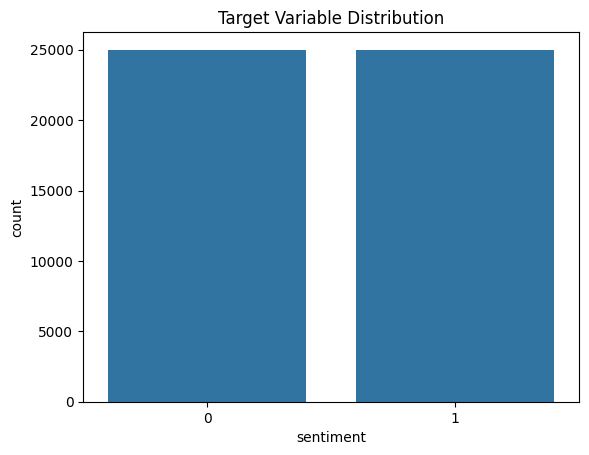

In [3]:
# 📊 Inspect Dataset
print(df.shape)
print('\n')
print(df.info())
print('\n')
print(df.head())
print('\n')

sns.countplot(x='sentiment', data=df)
plt.title('Target Variable Distribution')
plt.show()

In [4]:
# ✂️ Split Features and Labels
X = df["review"].values
y = df["sentiment"].values

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [5]:
# ⚙️ Tokenization
max_len = 256
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train_enc = tokenizer(list(X_train), truncation=True, padding='max_length', max_length=max_len, return_tensors='tf')
X_test_enc = tokenizer(list(X_test), truncation=True, padding='max_length', max_length=max_len, return_tensors='tf')

2025-06-03 10:31:50.108209: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-06-03 10:31:50.108243: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-06-03 10:31:50.108251: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
I0000 00:00:1748971910.108488 2250683 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1748971910.108736 2250683 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# Ensure labels are int for SparseCategoricalCrossentropy
y_train = y_train.astype("int")
y_test = y_test.astype("int")

In [7]:
# 🏗️ Build BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# 🏋️ Train Model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(
    {"input_ids": X_train_enc["input_ids"], "attention_mask": X_train_enc["attention_mask"]},
    y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=8,
    callbacks=[early_stop]
)

Epoch 1/5


2025-06-03 10:32:32.931272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
E0000 00:00:1748971953.519241 2250683 meta_optimizer.cc:967] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


4000/4000 [==============================] - 3172s 791ms/step - loss: 0.2568 - accuracy: 0.8947 - val_loss: 0.2327 - val_accuracy: 0.9086
Epoch 2/5
4000/4000 [==============================] - 2695s 674ms/step - loss: 0.1395 - accuracy: 0.9503 - val_loss: 0.2052 - val_accuracy: 0.9266
Epoch 3/5
4000/4000 [==============================] - 5963s 1s/step - loss: 0.0716 - accuracy: 0.9768 - val_loss: 0.2570 - val_accuracy: 0.9168
Epoch 4/5
4000/4000 [==============================] - 12124s 3s/step - loss: 0.0482 - accuracy: 0.9852 - val_loss: 0.2623 - val_accuracy: 0.9212


### **Please explain the results above. Why did it stop at Epoch 4/5?**

Great question. Here's what's happening based on the training log you shared:

---

### ✅ **Your setup and training ran successfully.**

The model trained for **4 full epochs**, not 5, because **early stopping** kicked in.

---

### ⚠️ Why Did It Stop at Epoch 4/5?

You added this callback:

```python
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
```

This means:

* Training will **stop early** if the **validation loss doesn’t improve** for 2 consecutive epochs.
* The model will **restore the weights from the epoch with the best validation loss**.

---

### 🧠 What Happened in Each Epoch:

| Epoch | Train Accuracy | Val Accuracy | Val Loss | Notes                          |
| ----- | -------------- | ------------ | -------- | ------------------------------ |
| 1     | 0.8947         | 0.9086       | 0.2327   | Good start                     |
| 2     | 0.9503         | 0.9266       | 0.2052   | Improved                       |
| 3     | 0.9768         | 0.9168       | 0.2570   | Val loss worsened              |
| 4     | 0.9852         | 0.9212       | 0.2623   | Val loss worsened again (2x) ❌ |
| 5     | **Not run**    | —            | —        | Stopped early 🚫               |

So:

* **Validation loss improved in Epoch 2**.
* Then worsened in **Epochs 3 and 4**.
* After **2 bad epochs**, early stopping halted training.

---

### 🧪 Should You Worry?

Not at all. This is **normal and good behavior**:

* Prevents overfitting.
* Saves time.
* The model already achieved **excellent accuracy (≥ 92%)**.

If you'd like to test more epochs:

* You can increase `patience=3` or higher.
* But watch out: if validation loss continues to rise, that’s a sign of **overfitting**.

---

### 🔍 Bonus Tip

You can see which epoch had the best validation performance:

```python
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f"Best epoch based on val_loss: {best_epoch}")
```

Let me know if you want to continue training from that point, test other models (like RoBERTa), or optimize inference time!


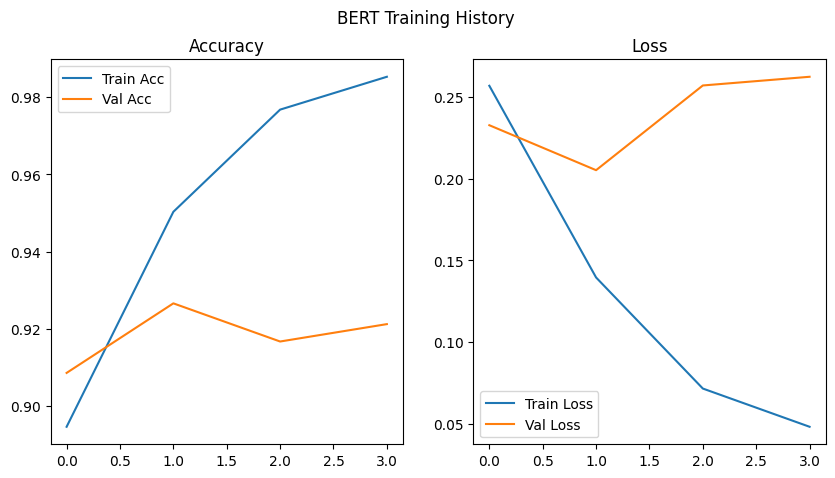

In [9]:
# 📈 Training Curves
def plot_training_curves(history, title="Training History"):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.suptitle(title)
    plt.show()

plot_training_curves(history, title="BERT Training History")

In [10]:
# 💾 Save Model
model_path = f"/Users/p24p/project-sentiment-analysis/bert_model_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
model.save_pretrained(model_path)
print(f"BERT model saved to: {model_path}")

BERT model saved to: /Users/p24p/project-sentiment-analysis/bert_model_20250603-171142


313/313 [==============================] - 252s 799ms/step


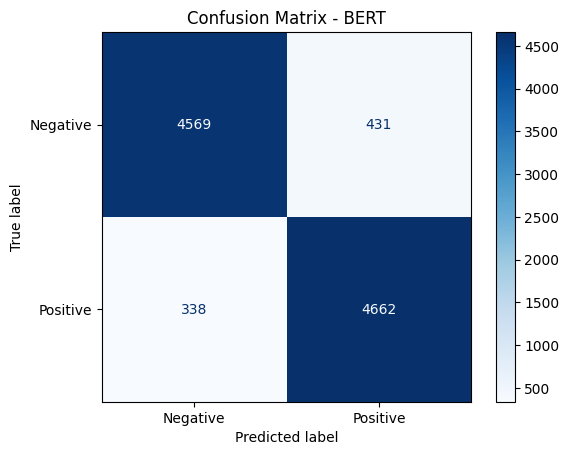


Classification Report (BERT):
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      5000
           1       0.92      0.93      0.92      5000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [11]:
# 🧠 Evaluation
logits = model.predict({"input_ids": X_test_enc["input_ids"], "attention_mask": X_test_enc["attention_mask"]}).logits
y_pred = np.argmax(logits, axis=1)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(cmap='Blues')
plt.title('Confusion Matrix - BERT')
plt.show()
print("\nClassification Report (BERT):\n", classification_report(y_test, y_pred))

You're looking above at the evaluation of your fine-tuned BERT model on the test set. Let's break down each part:

---

### 🔍 **Confusion Matrix**

```
              Predicted
              0     1
Actual  0   4569   431
        1    338  4662
```

#### What this means:

* **True Negatives (TN)** = 4569 → Correctly predicted class 0 (Negative)
* **False Positives (FP)** = 431 → Predicted Positive (1) but actually Negative (0)
* **False Negatives (FN)** = 338 → Predicted Negative (0) but actually Positive (1)
* **True Positives (TP)** = 4662 → Correctly predicted class 1 (Positive)

---

### 📊 **Classification Report**

| Metric        | Class 0 (Negative)                             | Class 1 (Positive) | Macro Avg | Weighted Avg |
| ------------- | ---------------------------------------------- | ------------------ | --------- | ------------ |
| **Precision** | 0.93                                           | 0.92               | 0.92      | 0.92         |
| **Recall**    | 0.91                                           | 0.93               | 0.92      | 0.92         |
| **F1-score**  | 0.92                                           | 0.92               | 0.92      | 0.92         |
| **Support**   | 5000                                           | 5000               | —         | —            |
| **Accuracy**  | 0.92 (overall correct: 4569+4662 = 9231/10000) |                    |           |              |

#### Definitions:

* **Precision** = TP / (TP + FP)
  → Of all predicted positives, how many were correct?
* **Recall** = TP / (TP + FN)
  → Of all actual positives, how many did we correctly identify?
* **F1-score** = Harmonic mean of precision and recall
  → Good measure of model performance when classes are balanced.

---

### ✅ **Summary**

* **Overall accuracy**: **92.3%**
* The model is **balanced**, doing equally well on both positive and negative reviews.
* **Very low false positive/negative rates**.
* This is an **excellent performance** for a binary sentiment classifier using BERT with relatively light tuning.

---

### 🧠 What You Could Do Next:

* **Examine misclassifications** (431 FP and 338 FN) to understand model weaknesses.
* **Try RoBERTa or DistilBERT** to see if you can maintain performance with faster inference.
* **Use a classification threshold** adjustment if false positives or false negatives are more costly in your application.

Would you like help visualizing misclassified examples or exporting these results?
